In [792]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from tabulate import tabulate


Data Extraction

In [793]:
#در این بخش دیتا ها را می خوانیم تا ساختار داده ها را بررسی کنیم
input_data=pd.read_csv("titanic.csv")
#input_data
input_data.info()
#input_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [794]:
#ابتدا چک می کنیم در کدام ستون ها مقدار خالی وجود دارد
input_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [795]:
#در ستون سن مقادیر خالی ای وجود دارد و برای این که در نتایج مان تاثیر نگذارد آن مقادیر را با میانگین سن مسافران پر می کنیم
input_data.fillna({"Age":input_data["Age"].mean()}, inplace=True)


In [796]:
#به این سه ستون نیازی نداریم چون هیچ ارتباطی بین آن ها وجود ندارد
input_data.drop(columns=["PassengerId","Name","Ticket"],inplace=True)


Encode columns

In [797]:
#به دلیل آن که ستون های عددی برای نیاز داریم، ستون جنسیت را به صفر و یک تبدیل می کنیم
input_data["Sex"] = input_data["Sex"].map({"male":1, "female":2})
# هم چنین برای ستون Embarked هم در ابتدا به حرف اول جایی که سوار شدن عدد نگاشت می کنیم تا مشخص شود کدام بندر بیشترین تکرار را دارد تا آن را بجای مادیر خالی در این ستون بگزاریم
input_data.fillna({"Embarked":"S"}, inplace=True)
input_data["Embarked"] = input_data["Embarked"].map({"S":1, "C":2, "Q":3})
#print(np.unique(input_data["Embarked"].dropna(), return_counts=True))



In [798]:
# در ستون کابین، حرف اول را فقط در نظر می گیریم و اعداد بعد از آن را در نظر نمی گیریم، سپس به بررسی تعداد مسافران در هر کابین می پردازیم
input_data["Cabin"] = input_data["Cabin"].astype(str).str[0]
print(input_data["Cabin"].value_counts(dropna=False))

Cabin
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64


In [799]:
# با توجه به نتیجه خروجی بالا، اگر همه موارد خالی را با مد ستون کابین پر کنیم، تحلیل مان اشتباه می شود چون اکثر مسافران می شوند از کابین c و هم چنین ممکن است که واقعا بعضی از افراد کابین نداشته باشند، پس یک دسته بندی جدید به نام unknown با مخفف u درست می کنیم و مقادیر خالی را با آن ها پر می کنیم

input_data["Cabin"] = input_data["Cabin"].astype(str).str[0]

input_data["Cabin"] = input_data["Cabin"].replace("n", "U")

input_data["Cabin"] = input_data["Cabin"].map({
    "A":1, "B":2, "C":3, "D":4, "E":5, "F":6, "G":7, "T":8, "U":0
})


In [800]:
input_data["Age"]=input_data["Age"].astype(np.uint8)


In [801]:
#با استفاده از این تابع همه داده ها را بررسی کرده و تا جایی که امکان دارد آن ها را کاهش حجم می دهیم
def auto_data_type(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        min_value = df[col].min()
        max_value = df[col].max()

        if pd.api.types.is_float_dtype(df[col]):
            df[col] = df[col].astype(np.float32)
        elif min_value >= 0:
            if max_value <= 255:
                df[col] = df[col].astype(np.uint8)
            elif max_value <= 65535:
                df[col] = df[col].astype(np.uint16)
            elif max_value <= 4294967295:
                df[col] = df[col].astype(np.uint32)
            else:
                df[col] = df[col].astype(np.uint64)
        else:
            if -128 <= min_value and max_value <= 127:
                df[col] = df[col].astype(np.int8)
            elif -32768 <= min_value and max_value <= 32767:
                df[col] = df[col].astype(np.int16)
            elif -2147483648 <= min_value and max_value <= 2147483647:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)
    return df

clean_df=auto_data_type(input_data)

#به بررسی مقدار حجم کاهش یا فته می پردازیم تا تغییرات را مشاهده کنیم. همان طور که دیده می شود حدود 88 درصد کاهش حجم رخ داده است.
clean_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    uint8  
 1   Pclass    891 non-null    uint8  
 2   Sex       891 non-null    uint8  
 3   Age       891 non-null    uint8  
 4   SibSp     891 non-null    uint8  
 5   Parch     891 non-null    uint8  
 6   Fare      891 non-null    float32
 7   Cabin     891 non-null    uint8  
 8   Embarked  891 non-null    uint8  
dtypes: float32(1), uint8(8)
memory usage: 10.6 KB


Remove outlier

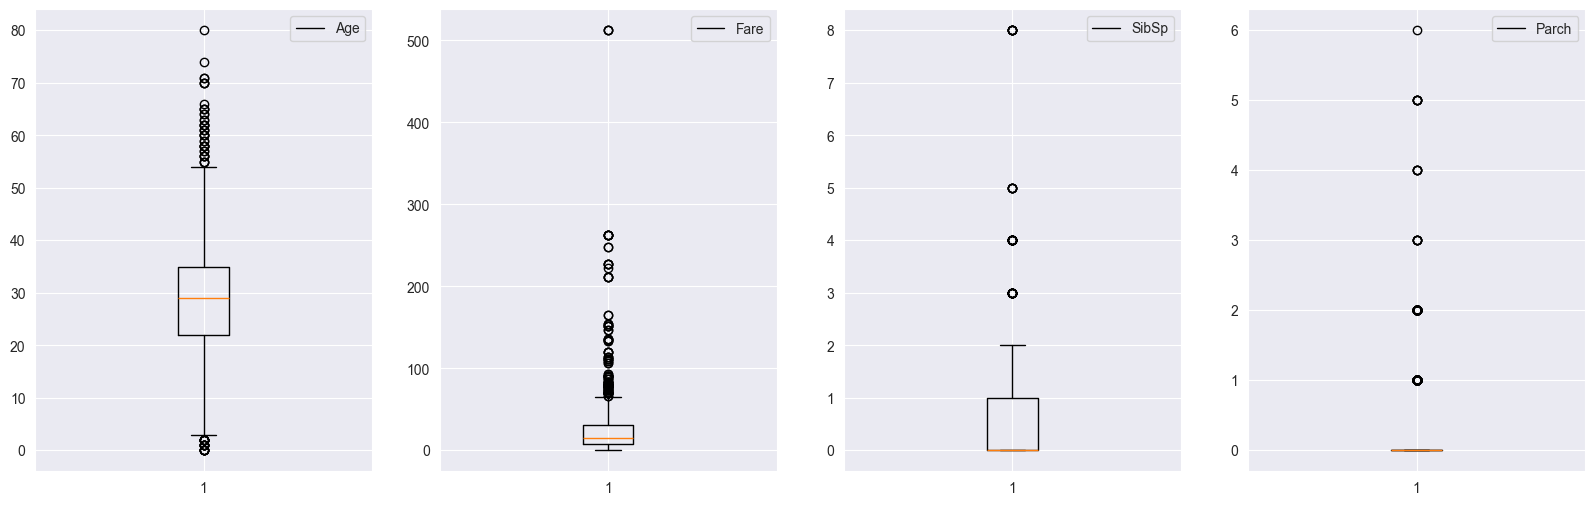

In [802]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,6))

cols = ["Age", "Fare", "SibSp", "Parch"]

for idx, ax in enumerate(axes.ravel()):
    ax.boxplot(clean_df[cols[idx]])
    ax.legend([cols[idx]])

# از پلات زیر می توان نتیجه گرفت که یک نفر بیشترین Fare داشته. پس آن را حذف می کنیم
clean_df = clean_df[clean_df["Fare"] != clean_df["Fare"].max()]

EDA

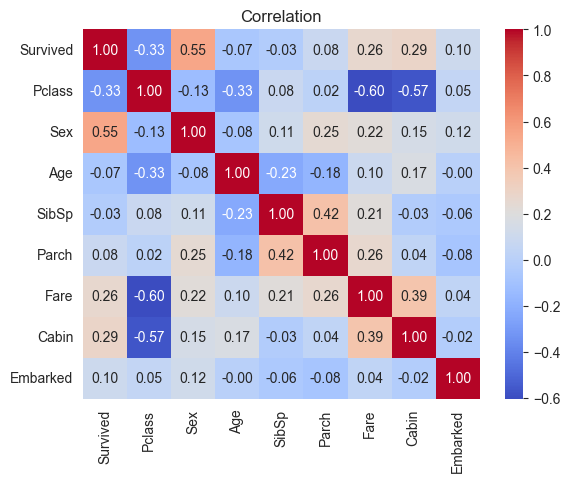

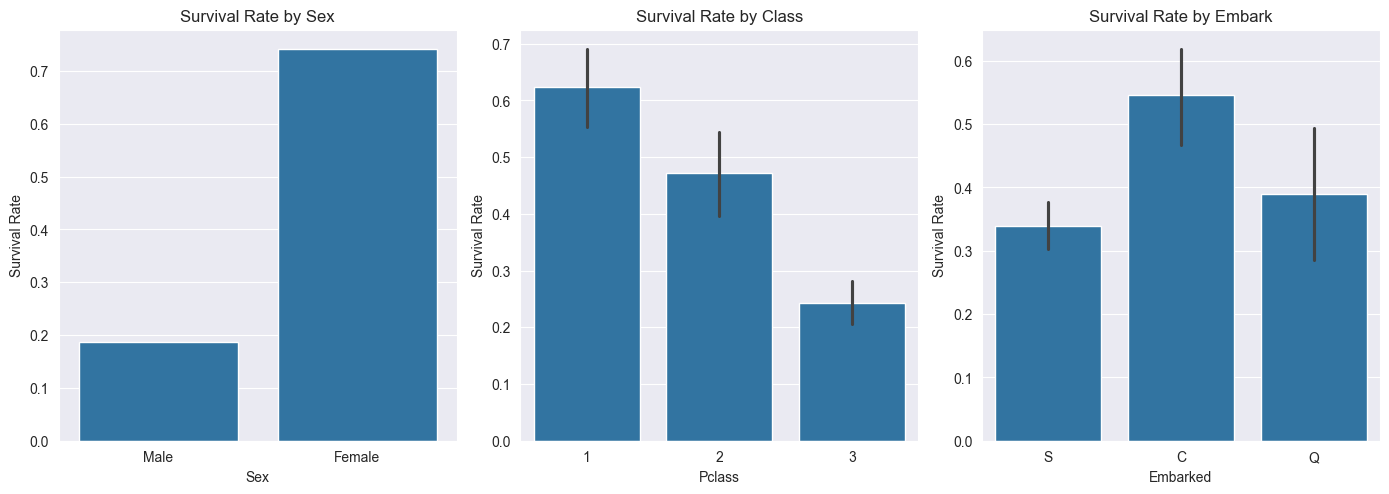

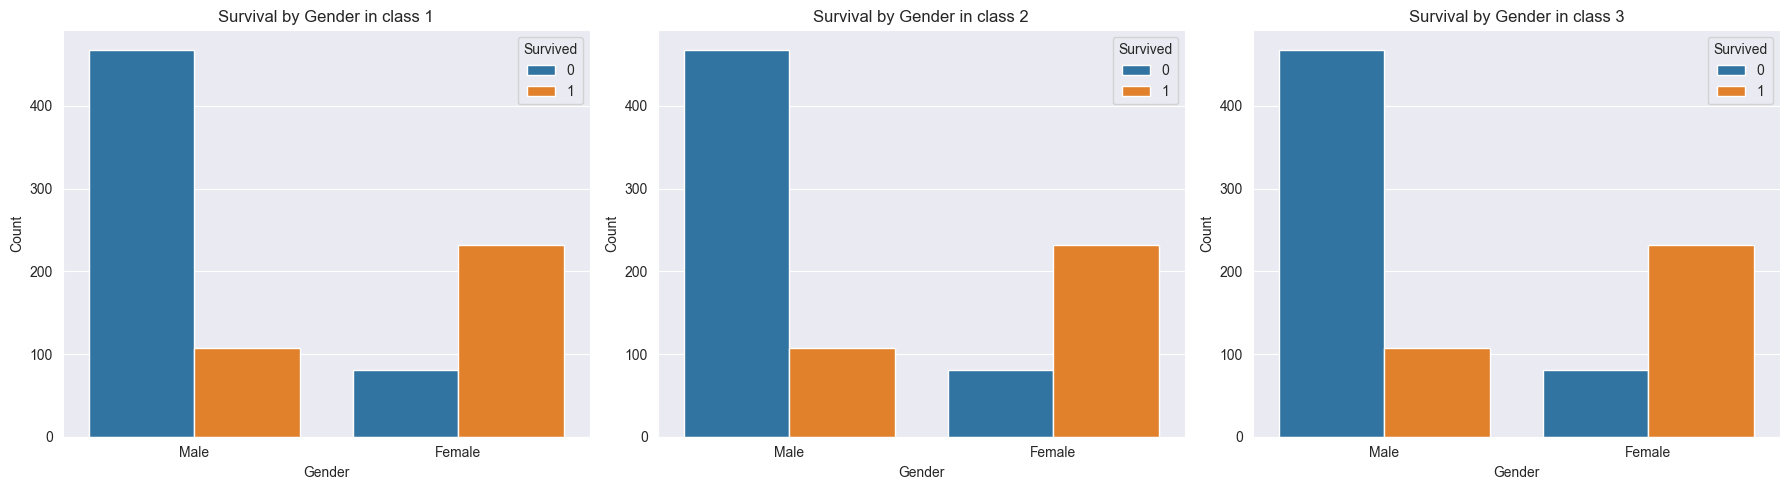

In [803]:
#جنسیت، پول بلیط و کلاس بلیط بیشترین تاثیر دارند.
sns.heatmap(clean_df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation")
plt.show()


clean_df_by_sex = clean_df.groupby("Sex")["Survived"].mean()
plt.figure(figsize=(14, 14))

plt.subplot(3, 3, 1)
#زنان نسبت به مردان نرخ نجات  بالاتری داشتند
sns.barplot(x=clean_df_by_sex.index, y=clean_df_by_sex.values)
plt.xticks([0, 1], ["Male", "Female"])
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Sex")

#مسافران کلاس 1 و کلاس 3 کمترین بیشتر نجات یافتند
plt.subplot(3, 3, 2)
sns.barplot(x="Pclass", y="Survived", data=clean_df)
plt.title("Survival Rate by Class")
plt.ylabel("Survival Rate")

#مسافرانی که از بندر C سوار شده‌اند، بالاترین نرخ نجات را داشتند
plt.subplot(3, 3, 3)
sns.barplot(x="Embarked", y="Survived", data=clean_df)
plt.xticks([0, 1, 2], ["S", "C", "Q"])
plt.title("Survival Rate by Embark")
plt.ylabel("Survival Rate")

plt.tight_layout()
plt.show()

classes = [1, 2, 3]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

#کلاس یک بیشتر و کلاس سه بسیار کمتر نجات پیدا کرده اند
#در کلاس 1، زنان  یک مقدار بیشتر نسبت به مردان نجات یافتند.
#در کلاس 2 زنان نسبت به مردان بیشتر نجات یافته بودند.
# در کلاس ۳ تعداد نجات یافته ها کم بوده اما با این حال زنان بیشتر از مردان نجات یافته اند
for idx, pclass in enumerate(classes):
    ax = axes[idx]
    class_df = clean_df[clean_df["Pclass"] == pclass]
    sns.countplot(data=clean_df, x="Sex", hue="Survived", ax=ax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Male", "Female"])
    ax.set_title(f"Survival by Gender in class {pclass}")
    ax.set_xlabel("Gender")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

# افرادی که کلاس 1 بودند و از بندر C سوار شده اند بیشتر نجات یافته اند

fig = px.histogram(clean_df, x="Pclass", color="Embarked", barmode="group", facet_col="Survived",
                   title="Survival by Class and Embarkation Port")
fig.show()


Supervised models

In [804]:
# ابتدا داده ها را استاندارد سازی و به داده های train, test تقسیم می کنیم
main_df = clean_df.copy()
X = main_df.drop(columns=['Survived'])
y = main_df['Survived']
# مدل knn را با k های مختلف تست شده ونتایج متغیر بود. یکی از کارهایی که میشه انجام داد تا به نتیجه یکسان برسیم این است که پارامتر های  random_state که نشان دهنده تقسیم داده‌ها در هر اجرا  و پارامتر stratify  که  توزیع یکسان نسبت کلاس ‌های بقا در داده های آموزش و تست را بر عهده دارد را ست کنیم.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

LogisticRegression model

In [805]:
model_logistic = LogisticRegression()

t0 = time.time()
model_logistic.fit(X_train_s, y_train)
t1 = time.time()

y_pred_default = model_logistic.predict(X_test_s)
t2 = time.time()

train_time_logistic   = t1 - t0
test_time_logistic = t2 - t1
acc_logistic= accuracy_score(y_test, y_pred_default)
prec_logistic= precision_score(y_test, y_pred_default)
recall_logistic= recall_score(y_test, y_pred_default)
f1_logistic= f1_score(y_test, y_pred_default)

Find best K

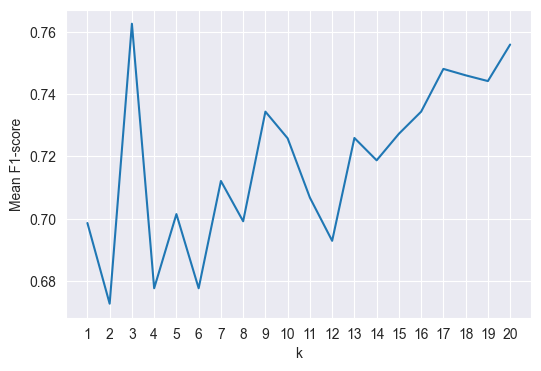

In [806]:
# با استفاده از f1-score در هر مرحله از انتخاب k بررسی می کنیم که مقدار k چقدر باشد تا بیشترین دقت را داشته باشیم.
k_range = range(1, 21)
f1_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_s, y_train)
    y_pred = knn.predict(X_test_s)
    f1_scores.append(f1_score(y_test, y_pred))

plt.figure(figsize=(6,4))
plt.plot(k_range, f1_scores)
plt.xticks(k_range)
plt.xlabel('k')
plt.ylabel('Mean F1-score')
plt.grid(True)
plt.show()

KNN model

In [807]:
# با توجه به نمودار بالا مقدار k را برابر 3 قرار می دهیم
model_knn = KNeighborsClassifier(n_neighbors=3)
t0 = time.time()
model_knn.fit(X_train_s, y_train)
t1 = time.time()
y_pred_knn = model_knn.predict(X_test_s)
t2 = time.time()
train_time_knn= t1 - t0
test_time_knn= t2 - t1
acc_knn= accuracy_score(y_test, y_pred_knn)
prec_knn= precision_score(y_test, y_pred_knn)
recall_knn= recall_score(y_test, y_pred_knn)
f1_knn= f1_score(y_test, y_pred_knn)

In [808]:
result = [
    ["LogisticRegression",train_time_logistic, test_time_logistic, acc_logistic,prec_logistic,recall_logistic,f1_logistic],
    ["KNN",train_time_knn,test_time_knn,acc_knn,prec_knn,recall_knn,f1_knn]
]

print(tabulate(
    result,
    headers=["Model","Train Time","Predict Time","Accuracy","Precision","Recall","F1-score"],
    tablefmt="github",
    floatfmt=".4f"
))

| Model              |   Train Time |   Predict Time |   Accuracy |   Precision |   Recall |   F1-score |
|--------------------|--------------|----------------|------------|-------------|----------|------------|
| LogisticRegression |       0.0101 |         0.0000 |     0.8427 |      0.8125 |   0.7647 |     0.7879 |
| KNN                |       0.0025 |         0.0031 |     0.8146 |      0.7465 |   0.7794 |     0.7626 |


Find the best parameters value in clustering models

In [809]:
# بر اساس معیار silhouette_score مناسب ترین مقادیر برای پارامتر های مدل های خوشه بندی را بدست می آوریم
# هم چنین با استفاده از معیار calinski_harabasz_score می توانستیم این پارامتر ها را تعیین کنیم
X_cluster = clean_df.drop(columns=["Survived"])
kmeans_best = (0, 0.0)
dbscan_best = (0.0, 0, 0.0)
hdbscan_best = (0, 0.0)

#
kmeans_max_sil = -1
dbscan_max_sil = -1
hdbscan_max_sil = -1

for k in range(2, 20):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_cluster)
    if len(set(labels)) <= 1:
        continue
    sil = silhouette_score(X_cluster, labels)
    
    if sil > kmeans_max_sil:
        kmeans_max_sil = sil
        kmeans_best = (k, sil)

for eps in np.arange(0.1, 1.0, 0.1):
    for min_samples in range(2, 20, 2):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X_cluster)
        if len(set(labels)) <= 1 or np.all(labels == -1):
            continue
        sil = silhouette_score(X_cluster, labels)
        
        if sil > dbscan_max_sil:
            dbscan_max_sil = sil
            dbscan_best = (eps, min_samples, sil)

for size in range(2, 20, 2):
    model = HDBSCAN(min_cluster_size=size)
    labels = model.fit_predict(X_cluster)
    if len(set(labels)) <= 1 or np.all(labels == -1):
        continue
    sil = silhouette_score(X_cluster, labels)
    
    if sil > hdbscan_max_sil:
        hdbscan_max_sil = sil
        hdbscan_best = (size, sil)

print(f"n_clusters = {kmeans_best[0]}")
print(f"eps = {dbscan_best[0]}, min_samples = {dbscan_best[1]}")
print(f"min_cluster_size = {hdbscan_best[0]}")



n_clusters = 2
eps = 0.8, min_samples = 2
min_cluster_size = 2


 Evaluate Classifier Models with Clustered Data

In [810]:
# داده ها را برای خوشه بندی استاندارد سازی می کنیم
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clean_df.drop(columns=["Survived"]))

#  الگوریتم‌ های خوشه‌ بندی را اجرا می کنیم
clean_df = clean_df.copy()
clean_df.loc[:, "cluster_KMeans"] = KMeans(n_clusters=kmeans_best[0], random_state=42).fit_predict(X_scaled)
clean_df.loc[:, "cluster_DBSCAN"] = DBSCAN(eps=dbscan_best[0], min_samples=dbscan_best[1]).fit_predict(X_scaled)
clean_df.loc[:, "cluster_HDBSCAN"] = HDBSCAN(min_cluster_size=hdbscan_best[0]).fit_predict(X_scaled)

# 3. حذف نقاط outlier از  DBSCAN
df_inliers = clean_df[clean_df["cluster_DBSCAN"] != -1].copy()

models = [("cluster_KMeans", "KMeans"), ("cluster_DBSCAN", "DBSCAN"), ("cluster_HDBSCAN", "HDBSCAN")]

results = []

# 5.  مدل‌های طبقه ‌بندی knn , LogisticRegression روی هر خوشه‌بندی اجرا می کنیم تا تاثیر خوشه بندی را بتوانیم متوجه شویم
for pair in models:
    cluster_col = pair[0]
    name = pair[1]

    #  ستون ‌های اضافی مدل های قبلی خوشه ‌بندی را در نظر نمی گیریم
    other_clusters = []
    for item in models:
        col_name = item[0]
        if col_name != cluster_col:
            other_clusters.append(col_name)

    #    دو مدل طبقه‌بندی LogisticRegression و KNN را بر روی هر مدل خوشه بندی اجرا می کنیم
    for clf_item in [(LogisticRegression(), "LogisticRegression"), (KNeighborsClassifier(n_neighbors=3), "KNN")]:
        clf = clf_item[0]
        clf_name = clf_item[1]

        # ستون survived در نظر نمی گیریم چون قرار هست لیبل بزنیم
        X = df_inliers.drop(columns=["Survived"] + other_clusters)
        y = df_inliers["Survived"]

        # تقسیم داده به آموزش و تست و انجام استاندارد سازی مجدد برای مدل ‌های طبقه ‌بندی
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        t0 = time.time()
        clf.fit(X_train, y_train)
        t1 = time.time()
        y_pred = clf.predict(X_test)
        t2 = time.time()

        results.append([
            name + " + " + clf_name,
            t1 - t0,
            t2 - t1,
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred)
        ])

print(tabulate(
    results,
    headers=["Model", "Train Time", "Predict Time", "Accuracy", "Precision", "Recall", "F1-score"],
    tablefmt="github",
    floatfmt=".4f"
))


| Model                        |   Train Time |   Predict Time |   Accuracy |   Precision |   Recall |   F1-score |
|------------------------------|--------------|----------------|------------|-------------|----------|------------|
| KMeans + LogisticRegression  |       0.0088 |         0.0000 |     0.8462 |      0.7907 |   0.7234 |     0.7556 |
| KMeans + KNN                 |       0.0000 |         0.0000 |     0.8182 |      0.7561 |   0.6596 |     0.7045 |
| DBSCAN + LogisticRegression  |       0.0000 |         0.0000 |     0.8531 |      0.8095 |   0.7234 |     0.7640 |
| DBSCAN + KNN                 |       0.0000 |         0.0000 |     0.8462 |      0.7907 |   0.7234 |     0.7556 |
| HDBSCAN + LogisticRegression |       0.0000 |         0.0000 |     0.8462 |      0.8049 |   0.7021 |     0.7500 |
| HDBSCAN + KNN                |       0.0000 |         0.0000 |     0.7972 |      0.6875 |   0.7021 |     0.6947 |
